TASK : CLassify cats and dogs using transfer learning, performace being enhanced with Image Augmentation and dropouts for this CNN

The first cell downloads the weights for a pre-trained inception network, and then instantiates a new instance of it using those weights. We will pull one of the convolutional layers as our input layer, and then take its output. We call this last output. 

In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  


from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

#Fun experimentation for mixed 7 layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-07-24 16:25:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   118MB/s    in 0.7s    

2021-07-24 16:25:40 (118 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


Now, we'll set up our model taking the last output as the input to it. That'll be flattened, and then there'll be a dense layer, a dropout, and an output layer.

In [3]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)               

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


The next cell will download the abbreviated version of cats versus dogs, unzip it into training and validation directories, and then set up the image generators. The training one will use augmentation as we've explored before.

In [4]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-07-24 16:25:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   276MB/s    in 0.2s    

2021-07-24 16:25:49 (276 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


We can then see that the images are being loaded and segregated into classes correctly, 2,000 for training, 1,000 for validation. We'll now start the training. I'm only going to do 20 epochs. 

In [5]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 51s - loss: 0.3519 - accuracy: 0.8605 - val_loss: 0.1203 - val_accuracy: 0.9490
Epoch 2/20
100/100 - 19s - loss: 0.2254 - accuracy: 0.9075 - val_loss: 0.1000 - val_accuracy: 0.9620
Epoch 3/20
100/100 - 17s - loss: 0.1823 - accuracy: 0.9270 - val_loss: 0.1292 - val_accuracy: 0.9570
Epoch 4/20
100/100 - 17s - loss: 0.1897 - accuracy: 0.9325 - val_loss: 0.0969 - val_accuracy: 0.9680
Epoch 5/20
100/100 - 18s - loss: 0.1709 - accuracy: 0.9435 - val_loss: 0.1209 - val_accuracy: 0.9580
Epoch 6/20
100/100 - 18s - loss: 0.1870 - accuracy: 0.9355 - val_loss: 0.1164 - val_accuracy: 0.9580
Epoch 7/20
100/100 - 17s - loss: 0.1729 - accuracy: 0.9405 - val_loss: 0.0984 - val_accuracy: 0.9630
Epoch 8/20
100/100 - 17s - loss: 0.1697 - accuracy: 0.9405 - val_loss: 0.0934 - val_accuracy: 0.9690
Epoch 9/20
100/100 - 18s - loss: 0.1655 - accuracy: 0.9425 - val_loss: 0.1222 - val_accuracy: 0.9660
Epoch 10/20
100/100 - 18s - loss: 0.1763 - accuracy: 0.9415 - val_loss: 0.1347 - val_accura

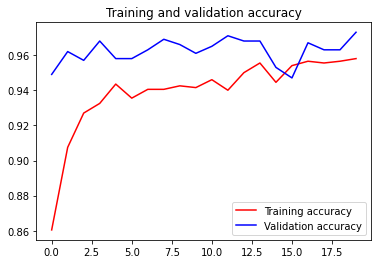

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()